# Assignment 2  - Classification
### Due Date: 23 October 11.59pm (or 26 October 11.59pm if late period is used)
Sentences in <span style="color:blue">blue</span> indicate questions to be answered. 

If you wish to type math equations in markdown, follow this link: https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html#LaTeX-equations

Please save this Jupyter notebook as __YourNameInLumiNUS_YourNUSNETID.ipynb__.

If you have further questions, you can post on the LumiNUS forums, or email Guilherme Zagatti (gzagatti@u.nus.edu) or the lecturer, Bryan Hooi (bhooi@comp.nus.edu.sg).

### Introduction
In this assignment, you are a data scientist at the Pima Womans Hospital of Arizona. You have been asked by the hospital to develop a computer program that can accurately diagnose whether a patient has diabetes. You are provided with a dataset containing historical records of measurements and outcomes. You will be using some common data mining libraries to achieve your objective. Detailed instructions and questions are given in the following sections.

### Dataset
The Pima Indians of Arizona have the highest rate of obesity and diabetes ever recorded. This dataset was collected by the National Institute of Diabetes and Digestive and Kidney Diseases, with the objective to predict whether or not a patient has diabetes based on certain diagnostic measurements. All the patients recorded in this dataset are females of the Pima Indian heritage. The dataset consists of 8 medical predictor variables and one target variable, Outcome. Table 1 shows the description of each variable. Your task is to build classiﬁcation models for predicting Outcome based on the other variables.


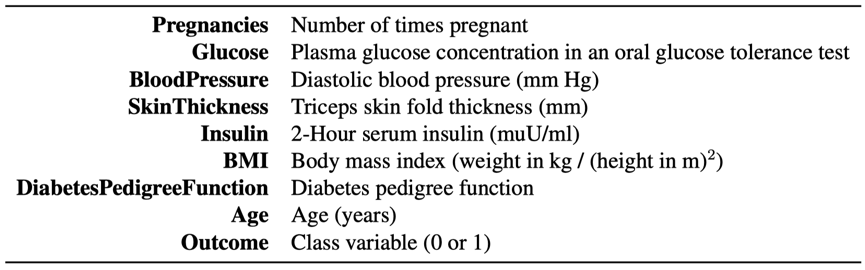

**----- Import all libraries here -----**

In [1]:
# data manipulation
import pandas as pd
import numpy as np

# visualization
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

# model training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer

# classifiers
from sklearn.naive_bayes import GaussianNB # naive bayes
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.tree import DecisionTreeClassifier # decision Tree
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingClassifier

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Data Cleaning and Analysis (15 points)

<span style="color:blue">Load the CSV file into a *DataFrame* object named **pima** using Pandas to examine the dataset and perform data cleaning:</span>
    
<span style="color:blue">1) Print the dtype of each column to review the data types of the attributes in the dataset. *(2 points)*</span>

In [2]:
# --- Your code here ---
pima = pd.read_csv("diabetes.csv")
pima.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure               float64
SkinThickness               float64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

<span style="color:blue">2) Are there any missing values in the dataset? For each attribute in the dataset, print out the total number of missing values in the dataset for that attribute. Drop the rows which have a missing value in any of their columns. *(3 points)*
<br/>
</span>

In [3]:
print('Before replacing missing values:')
# --- Your code to print the no. of missing values per column:
missing_column_value = pima.isnull().sum(axis=0)
print(missing_column_value)
pima = pima.dropna(axis=0, how='any')
print("\n")
print("After dropping missing values:")
missing_column_value_2 = pima.isnull().sum(0)
print(missing_column_value_2)
# --- Your code to remove missing values:


Before replacing missing values:
Pregnancies                 0
Glucose                     0
BloodPressure               1
SkinThickness               1
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    1
Age                         0
Outcome                     0
dtype: int64


After dropping missing values:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


<span style="color:blue">3) Show the count of “0”s and “1”s in *Outcome* using a bar graph. Write down what you observe in the bar plot. Assuming that we regard this distribution as reasonably unbalanced, how does this observation affect what metrics you would use to evaluate a classifier for predicting *Outcome*?*(5 points)*
<br/>_(Hint: you can draw the bar plot with the help of **sb.countplot**.)_
</span>

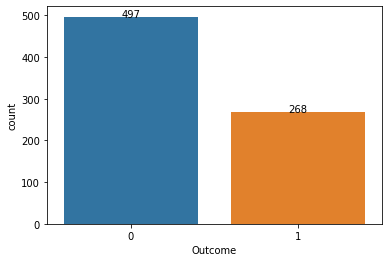

In [4]:
# --- Your code here ---
outcome_col = pima['Outcome'].value_counts()
ax = sb.countplot(x ='Outcome', data = pima) 
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1, outcome_col.get(i),ha="center")

<b>Answer:</b>
Amount of Outcome 0 is nearly double to amount of Outcome 1. We should not use accuracy and specificity mertrics to evaluate performance of classification model, because accurarcy and specificity metrics often give high scores in training, even though model tends to return 0 and have wrong predictions with false nagative and false positve. In this case, it it better to use F1-score which doesn't depend on high skew of Outcome 0

<span style="color:blue">4) Generate a 9x9 heatmap plot showing the correlation between any two features (including target: outcome), as follows: **sb.clustermap(pima.corr(), annot=True)**. What does the heatmap suggest about the features that may be most useful in predicting *Outcome*? *(5 points)*<br/>

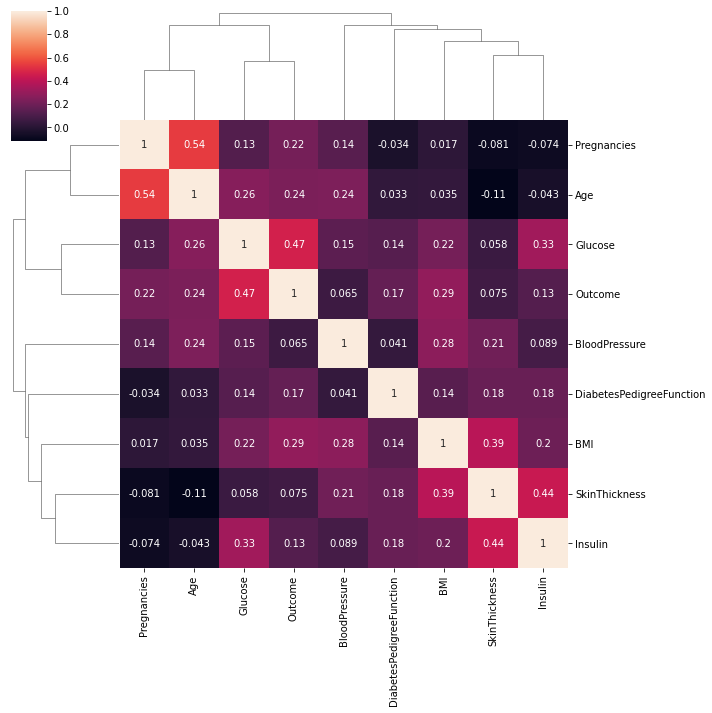

In [5]:
# --- Your code here ---
sb.clustermap(pima.corr(), annot=True)

<b>Answer:</b>
According to the heat map, two features which have high correlation, are dependent and similar together. Hence, we can reduce dimension of dataset by removing one feature from that pair, it is efficient to help training faster and improve accuracy for classification models

## 2. Feature Transformation (15 points)

We observe that all the variables in the dataset except the target variable *Outcome* are continuous. In this section, you will perform feature transformation on the continuous variables to generate two sets of features that will be used in the subsequent classification task.

**Feature Set 1 - Continuous to Categorical**

<span style="color:blue">1) Often when dealing with continuous variables like *Glucose* or *BMI*,  we may wish  to transform these continuous variables into categorical variables, which may be better predictors of *Outcome*. Cut the continuous values of each feature into non-overlapping buckets: for *Glucose*, adopt the glucose level guidelines given by American Diabetes Association:<br/>
*- Normal: $< 140$mg/dl of glucose,<br/>*
*- Prediabetes: $\ge 140$ but $<200$mg/dl of glucose,<br/>*
*- Diabetes: $> 200$mg/dl of glucose<br/>*
To do this, setting **inf = float('inf')**, you can use **pd.cut** with bins of **[-inf,139.99,199.99,inf]** and labels of **['Normal', 'Prediabetes', 'Diabetes']**. Similarly, for *BMI*, use a similar approach with the cutoffs (from the World Health Organization):<br>
*- Underweight: $< 18.5$<br/>*
*- Normal: $\ge 18.5$ but $<25$<br/>*
*- Overweight: $\ge 25$ but $<30$<br/>*
*- Obese: $\ge 30$<br/>*
Keep the remaining variables (other than *Glucose* and *BMI*) unchanged. Name the resulting DataFrame as __pima1__. pima1 should still contains 9 columns with the same set of column names as pima. Use **pima1.head()** to show the top rows. *(8 points)*</span>
    

In [6]:
# --- Your code here ---
inf = float('inf')
glucose_categogy = pd.cut(pima.Glucose,bins=[-inf,140,200,inf],
                          labels=['Normal', 'Prediabetes', 'Diabetes'], right = False)
bmi_category = pd.cut(pima.BMI,bins=[-inf,18.5,25,30,inf],
                      labels=['Underweight', 'Normal', 'Overweight', 'Obese'], right = False)
pima1 = pima.assign(Glucose=glucose_categogy, BMI=bmi_category)
print(pima1.shape)
pima1.head()
# --- End of your code ---


(765, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,Prediabetes,72.0,35.0,0,Obese,0.627,50,1
1,1,Normal,66.0,29.0,0,Overweight,0.351,31,0
2,8,Prediabetes,64.0,0.0,0,Normal,0.672,32,1
3,1,Normal,66.0,23.0,94,Overweight,0.167,21,0
4,0,Normal,40.0,35.0,168,Obese,2.288,33,1


<span style="color:blue">2) Next, we convert the generated categorical features (**Glucose** and **BMI**) into binary features using the one-hot encoding scheme: given a categorical feature containing $m$ categories, one-hot encoding will encode each value into a vector of size $m$ with only one of its values as 1 (indicating it as active), and its other values as 0. Use **pima1.head()** to show the top rows of the encoded **pima1**. *(5 points)*</span>

<span style="color:blue">*(Hint: you can use **pd.getdummies()** to convert each desired categorical feature in **pima1** into multiple one-hot features.)*</span>

In [7]:
# --- Your code here ---
pima1 = pd.get_dummies(pima1,columns=['Glucose', 'BMI'])
print(pima1.shape)
pima1.head()
# --- End of your code ---

(765, 14)


,Pregnancies,BloodPressure,SkinThickness,Insulin,DiabetesPedigreeFunction,Age,Outcome,Glucose_Normal,Glucose_Prediabetes,Glucose_Diabetes,BMI_Underweight,BMI_Normal,BMI_Overweight,BMI_Obese
0,6,72.0,35.0,0,0.627,50,1,0,1,0,0,0,0,1
1,1,66.0,29.0,0,0.351,31,0,1,0,0,0,0,1,0
2,8,64.0,0.0,0,0.672,32,1,0,1,0,0,1,0,0
3,1,66.0,23.0,94,0.167,21,0,1,0,0,0,0,1,0
4,0,40.0,35.0,168,2.288,33,1,1,0,0,0,0,0,1


**Feature Set 2 - Continuous Features**

<span style="color:blue">3) For the second feature set, we use the original continuous variables from **pima** unchanged. Construct a new copy, **pima2** of the original **pima** dataset. Show its top rows using **pima2.head()**. *(2 points)*</span>

In [8]:
# --- Your code here ---
pima2 = pima.copy()
print(pima2.shape)
pima2.head()
# --- End of your code ---


(765, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72.0,35.0,0,33.6,0.627,50,1
1,1,85,66.0,29.0,0,26.6,0.351,31,0
2,8,183,64.0,0.0,0,23.3,0.672,32,1
3,1,89,66.0,23.0,94,28.1,0.167,21,0
4,0,137,40.0,35.0,168,43.1,2.288,33,1


## 3. Model Construction (30 points)

Your task in this section is to use the derived feature sets from the previous section to construct classification models for diabetes outcome prediction (0 or 1).  We have split the data into training and test sets for you as shown below (you need to run the cell below): e.g. x_train1 and y_train1 are the training features and labels for **pima1**.

In [9]:
# pima1 split
x1 = pima1.drop(columns='Outcome')
y1 = pima1['Outcome']
x_train1, x_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size = 0.25, random_state=0)

# pima2 split
x2 = pima2.drop(columns='Outcome')
y2 = pima2['Outcome']
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size = 0.25, random_state=0)

print(x1.shape, y1.shape)
print(x2.shape, y2.shape)

(765, 13) (765,)
(765, 8) (765,)


<span style="color:blue">1) Experiment with the 5 classification models below from scikit-learn (directly using the scikit-learn functions imported with their default hyperparameter settings on **pima1** and **pima2** (You should thus perform $5 \times 2$ times of model training and evaluation, for the 5 models and 2 feature sets):<br/></span>

<span style="color:blue">- KNN</span><br/>
<span style="color:blue">- logistic regression</span><br/>
<span style="color:blue">- decision tree<br/></span>
<span style="color:blue">- random forest<br/></span>
<span style="color:blue">- gradient boosting machine<br/></span>
    
<span style="color:blue">You should perform model training on x_train1 and x_train2,  and perform evaluation on x_test1 and x_test2.  Use **accuracy** and **weighted F1** as evaluation metrics, and save the results of different models in the defined lists **pima1_acc**, **pima2_acc**, **pima1_f1**, **pima2_f1**. Note that the order of results in each list should match the model order provided in **model_names**. Print the **accuracy_record** table and **F1_record** table using the provided code. *(13 points)*</span>

In [10]:
# K-nearest neighbors, Logistic regression, Decision trees, Random forest, Gradient boosting machine
model_names = ['KNN', 'LR', 'DT', 'RF', 'GBM']
pima1_acc = []
pima2_acc = []
pima1_f1 = []
pima2_f1 = []

# --- Your code here ---
classifiers1  = [KNeighborsClassifier(),
                LogisticRegression(),
                DecisionTreeClassifier(),
                RandomForestClassifier(),
                GradientBoostingClassifier()]

classifiers2  = [KNeighborsClassifier(),
                LogisticRegression(),
                DecisionTreeClassifier(),
                RandomForestClassifier(),
                GradientBoostingClassifier()]

for model in classifiers1:
    model.fit(x_train1, y_train1)
    y_pred1 = model.predict(x_test1)
    acc = round(accuracy_score(y_test1, y_pred1) * 100, 2)
    f1 = round(f1_score(y_test1, y_pred1, average='weighted') * 100, 2)
    pima1_acc.append(acc)
    pima1_f1.append(f1)
    
for model in classifiers2:
    model.fit(x_train2, y_train2)
    y_pred2 = model.predict(x_test2)
    acc = round(accuracy_score(y_test2, y_pred2) * 100, 2)
    f1 = round(f1_score(y_test2, y_pred2, average='weighted') * 100, 2)
    pima2_acc.append(acc)
    pima2_f1.append(f1)
    
# please use the following function to calculate f1 and acc
# f1 = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)
# acc = round(accuracy_score(y_test, y_pred) * 100, 2)

# --- End of your code ---

accuracy_record = pd.DataFrame({'Model': model_names, 'pima1_acc': pima1_acc, 'pima2_acc': pima2_acc})
accuracy_record['acc_mean'] = accuracy_record.mean(axis=1).round(2)
accuracy_record.set_index('Model', inplace=True)
accuracy_record.loc['avg'] = accuracy_record.mean().round(2)

F1_record = pd.DataFrame({'Model': model_names, 'pima1_f1': pima1_f1, 'pima2_f1': pima2_f1})
F1_record['F1_mean'] = F1_record.mean(axis=1).round(2)
F1_record.set_index('Model', inplace=True)
F1_record.loc['avg'] = F1_record.mean().round(2)

print(accuracy_record)
print('\n')
print(F1_record)

       pima1_acc  pima2_acc  acc_mean
Model                                
KNN        68.75      72.92     70.84
LR         77.08      80.21     78.64
DT         65.62      71.88     68.75
RF         72.92      74.48     73.70
GBM        73.96      77.60     75.78
avg        71.67      75.42     73.54


       pima1_f1  pima2_f1  F1_mean
Model                             
KNN       67.96     72.67    70.32
LR        76.36     79.58    77.97
DT        66.53     71.88    69.20
RF        72.53     73.91    73.22
GBM       73.45     77.10    75.28
avg       71.37     75.03    73.20


<span style="color:blue">2) According to the results above, which feature set is better, pima1 or pima2? Select the better one to be used in the following tasks. *(1 points)*</span>

<b>Answer:</b>
pima2 is better because models which are trained on feature set pima2, gave accurary scores and F1 scores higher than training on pima1

<span style="color:blue">3) According to the results above, which model would you recommend to the hospital? *(1 points)*</span>

<b>Answer:</b>
logistic regression is recommended to the hospital, because it gave highest scores on both feature set pima1 and pima2 

<span style="color:blue">4) Select any of the 5 classification models from 1). Perform grid search with 10 fold cross-validation for tuning any of its hyperparameters (at least one, but more are acceptable) on the training set of either **pima1** or **pima2** (according to your choice in 2)), using accuracy as the scoring metric. Print the configuration of the best selected model and its prediction **accuracy** and **weighted F1** scores on the corresponding test set. *(10 points)*</span>

<span style="color:blue">*(Hint: Use **sklearn.model_selection.GridSearchCV** for grid search.)*</span>

<b>Answer:</b>
- LogisticRegression is selected and the best tuned hyperparameters are {'C': 166.81005372000558, 'penalty': 'l2', 'solver': 'lbfgs'}
- Applying LogisticRegression with the best tuned hyperparameters for traning on pima2 , we get accuracy score: 81.77 and f1 score: 81.14


In [11]:
# --- Your code here ---
lr_model = LogisticRegression()

# Create hyperparameter options
penalty = ['l1', 'l2']
C =  np.logspace(-4, 4, 10)
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

hyperparameters = dict(C=C, penalty=penalty, solver=solver)

lr_cv = GridSearchCV(lr_model, hyperparameters, cv=10, verbose=0, scoring = 'accuracy')
lr_cv.fit(x_train2, y_train2)
print("The best hyperparameters: ",lr_cv.best_params_)



The best hyperparameters:  {'C': 166.81005372000558, 'penalty': 'l2', 'solver': 'lbfgs'}


In [12]:
best_lr = LogisticRegression(penalty='l2', C=166.81005372000558, solver= 'lbfgs')
best_lr.fit(x_train2, y_train2)
besty_pred2 = best_lr.predict(x_test2)
print("Accuracy score: ",round(accuracy_score(y_test2, besty_pred2) * 100, 2))
print("F1 score: ",round(f1_score(y_test2, besty_pred2, average='weighted') * 100, 2))



Accuracy score:  81.77
F1 score:  81.14


<span style="color:blue">5) Suppose your model is experiencing low training error but high test error, i.e. overfitting. For each of the 5 methods, select one of its hyperparameters (i.e. any input argument that could be passed to its scikit-learn training function) and state how the hyperparameter could be modified to address the problem of overfitting. (Justification is not required) *(5 points)*</span>

<b>Answer:</b>
- KNeighborsClassifier : hyperparameter <b>n_neighbors</b>. If the value is too small, it tends to be overfitting, but if the value is too big, it tends to be underfitting. Therefore, it need to be chosen wisely to get good prediction
<br/>

- Logistic Regression :  hyperparameters <b>penalty</b> and <b>C</b> to control overfitting. Panenty is a regularizaton parameter with options L1 and L2. Regularization value will be added to cost/loss function, it aims to reduce values of weight parameters of models to avoid overfitting. Moreover, C is inverse of regularization strength, it controls contribution of regularization to the cost function
<br/>

- DecisionTreeClassifier : hyperparameter <b>ccp_alpha</b>. When depth of tree is high, likely overfitting happens, so we set appropriate value of ccp_alpha to prune the tree, it helps to prevent overfitting 
<br/>

- RandomForestClassifier : hyperparameter <b>n_estimators</b>. It is the number of trees in training. To reduce overfitting, we can set n_estimators to high value, but this leads to more computational expenses
<br/>

- GradientBoostingClassifier : hyperparameter <b>min_samples_split</b>. It represents the minimum number of samples that feature can be splitted in internal node. We need to set an approriate value of min_samples_split to avoid high depth of tree which causes overfitting. However, if the value is set too high, this will cause underfitting 